In [18]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams.update({'font.size' : 18})

# About
__Author:__ Pat McCornack  
__Date:__ February 2025  
__Purpose:__ Explore the relationship between GOES Coastal Low Clouds (CLC) and Fog Drip at sites across the island.  

__Caveat:__ The GOES dataset is daylight hours only, so this analysis only applies to daylight hours. Most fog occurs at night, so this is a major drawback. 

# Read in Data

In [19]:
root_dir = Path().resolve().parents[1]
met_fpath = root_dir / 'data' / '02-clean' / 'combined-sites.csv'
clc_fpath = root_dir / 'data' / '02-clean' / 'sites-clc.csv'

met_df = pd.read_csv(met_fpath, index_col=0)
clc_df = pd.read_csv(clc_fpath, index_col=0)

met_df['time (PST)'] = pd.to_datetime(met_df['time (PST)'])
clc_df['time-PDT'] = pd.to_datetime(clc_df['time-PDT'])
clc_df['time (PST)'] = clc_df['time-PDT'] - pd.Timedelta(hours=1)  # Convert tz
clc_df = clc_df.drop('time-PDT', axis=1)

met_df = met_df.set_index(['site', 'time (PST)'])
clc_df = clc_df.set_index(['site', 'time (PST)'])

# Create categorical variables
met_df['fog-binary'] = met_df['fog'].apply(lambda x: 1 if x > 0 else 0)
met_df['rh-fog'] = met_df['relative humidity (%)'].apply(lambda x: 1 if x > 97 else 0)
met_df['condition'] = met_df.apply(lambda x: 'both' if x['fog'] > 0 and x['rain (mm)'] > 0
                                   else 'fog' if x['fog'] > 0
                                   else 'rain' if x['rain (mm)'] > 0
                                   else 'clear', axis=1)

# Join the dataframes
join_df = met_df.join(clc_df, how='inner').reset_index()

join_df.head()

,site,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),par (micromol/m2/s),...,atm pressure (mb),leaf wetness (mv),solar radiation (wm2),atm pressure (kpa),leaf wetness (%),fog-binary,rh-fog,condition,cldalb,cld-binary
0,wrdg,2004-05-01 06:00:00,0.0,13.770000,60.400002,NaN,NaN,NaN,0.0,196.30000,...,NaN,NaN,NaN,NaN,NaN,0,0,clear,10.39,1
1,wrdg,2004-05-01 06:30:00,0.0,14.400000,67.099998,NaN,NaN,NaN,0.0,408.79999,...,NaN,NaN,NaN,NaN,NaN,0,0,clear,4.75,0
2,wrdg,2004-05-01 07:00:00,0.0,14.850000,76.000000,NaN,NaN,NaN,0.0,631.29999,...,NaN,NaN,NaN,NaN,NaN,0,0,clear,3.65,0
3,wrdg,2004-05-01 07:30:00,0.0,15.710000,77.500000,NaN,NaN,NaN,0.0,851.29999,...,NaN,NaN,NaN,NaN,NaN,0,0,clear,6.03,0
4,wrdg,2004-05-01 08:00:00,0.0,17.139999,71.599998,NaN,NaN,NaN,0.0,1061.30000,...,NaN,NaN,NaN,NaN,NaN,0,0,clear,4.94,0


# QA/QC Checks

In [20]:
# Drop the relatively few missing cldalb values
print(join_df.isna().sum())
join_df = join_df.dropna(subset='cldalb')

site                          0
time (PST)                    0
fog                           0
air temperature (C)        2601
relative humidity (%)      2599
wind speed (m/s)          15907
wind gust (m/s)           17975
wind direction (deg)      17975
rain (mm)                     0
par (micromol/m2/s)       55782
dew point (C)             61442
leaf wetness              48389
soil moisture             50018
fog tips                      0
solar radiation (kwm2)    76531
atm pressure (mb)         88926
leaf wetness (mv)         88926
solar radiation (wm2)     88926
atm pressure (kpa)        88926
leaf wetness (%)          88926
fog-binary                    0
rh-fog                        0
condition                     0
cldalb                      196
cld-binary                    0
dtype: int64


## RH = 0 
Relative humidity values of 0 are unlikely on the island. Check the frequency of these values and the conditions during which they occur.

There's a spike at 0, which is suspicious. I chose to remove all values where RH is 0. 

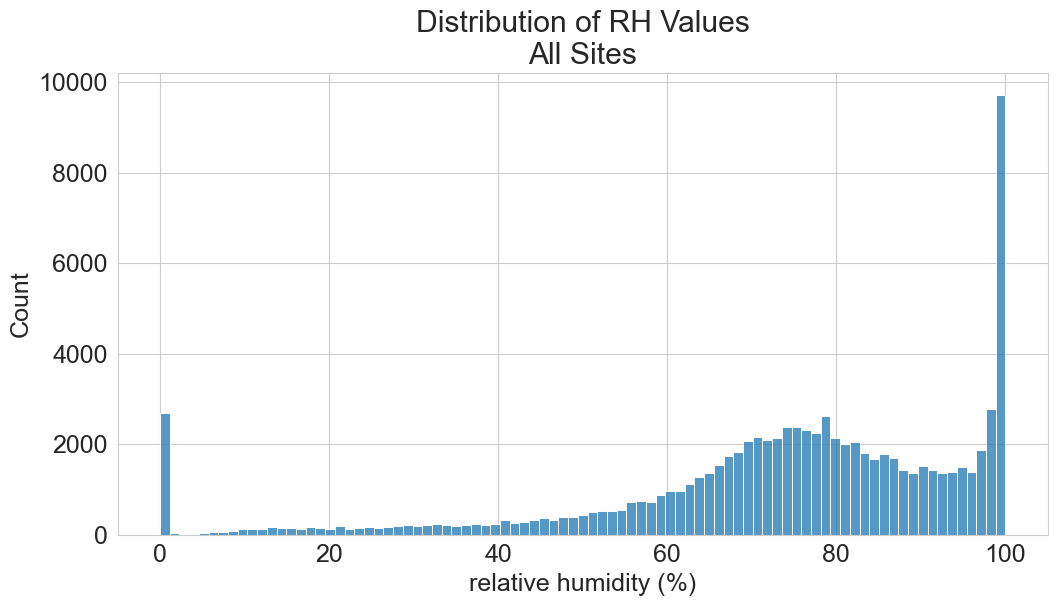

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(join_df['relative humidity (%)'], ax=ax)
ax.set(title='Distribution of RH Values\nAll Sites')
plt.show()

In [22]:
df_0rh = join_df.loc[join_df['relative humidity (%)'] == 0]
print(df_0rh.shape)
df_0rh.describe()

(2655, 25)


,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),par (micromol/m2/s),dew point (C),...,solar radiation (kwm2),atm pressure (mb),leaf wetness (mv),solar radiation (wm2),atm pressure (kpa),leaf wetness (%),fog-binary,rh-fog,cldalb,cld-binary
count,2655,2655.000000,2654.000000,2655.0,2655.000000,2655.000000,2655.000000,2655.0,2655.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2655.000000,2655.0,2655.000000,2655.000000
mean,2006-06-27 18:29:52.542372992,0.000904,20.711575,0.0,2.566437,4.530591,189.016083,0.0,1415.413933,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001130,0.0,7.048547,0.158945
min,2005-08-23 11:30:00,0.000000,7.430000,0.0,0.000000,0.000000,0.000000,0.0,18.799999,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000
25%,2006-05-30 14:15:00,0.000000,16.379999,0.0,1.480000,3.150000,39.299999,0.0,927.549990,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,2.240000,0.000000
50%,2006-07-02 13:30:00,0.000000,20.190001,0.0,2.230000,4.270000,287.799990,0.0,1541.300000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,3.430000,0.000000
75%,2006-08-09 07:45:00,0.000000,24.790001,0.0,3.530000,5.570000,297.600010,0.0,1940.050000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,5.750000,0.000000
max,2006-09-30 14:00:00,2.000000,35.700001,0.0,9.280000,15.030000,355.200010,0.0,2326.300000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,78.190000,1.000000
std,NaN,0.039198,5.172295,0.0,1.533441,2.157397,127.229547,0.0,590.699104,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.033602,0.0,11.210556,0.365694


In [ ]:
# Remove observations where RH = 0
join_df = join_df.loc[join_df['relative humidity (%)'] > 0]

## Rain / Fog Comparison
From previous observations, we know that 1) rain is infrequent during the summer, and 2) bycatch of rain by fog harps is likely. Check the frequency of these events and their overlap with fog. 

I chose to remove these events because they're rare, but do impact the fog signal. 

In [24]:
rain_df = join_df.loc[join_df['rain (mm)'] > 0]
print("Number of observations with rain > 0:", rain_df.shape[0])
print("Number of observations with rain > 0 and CLC = True:", rain_df.loc[rain_df['cldalb'] > 0].shape[0])
rain_df.describe()

Number of observations with rain > 0: 311
Number of observations with rain > 0 and CLC = True: 311


,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),par (micromol/m2/s),dew point (C),...,solar radiation (kwm2),atm pressure (mb),leaf wetness (mv),solar radiation (wm2),atm pressure (kpa),leaf wetness (%),fog-binary,rh-fog,cldalb,cld-binary
count,311,311.000000,311.000000,311.000000,204.000000,194.000000,194.000000,311.000000,54.000000,54.000000,...,72.000000,0.0,0.0,0.0,0.0,0.0,311.00000,311.000000,311.000000,311.000000
mean,2008-05-03 06:48:02.315112448,3.001734,12.936695,94.816849,1.658275,3.128505,237.640670,0.353603,375.281477,12.241852,...,0.149139,NaN,NaN,NaN,NaN,NaN,0.33119,0.652733,43.807652,0.861736
min,2004-06-30 17:00:00,0.000000,6.273000,12.250000,0.000000,0.000000,0.000000,0.100000,13.800000,-10.820000,...,0.005000,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.110000,0.000000
25%,2005-09-26 15:00:00,0.000000,11.589500,94.775000,0.835500,1.750000,163.624993,0.100400,134.425000,11.885000,...,0.051250,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,30.090000,1.000000
50%,2007-05-16 09:30:00,0.000000,13.280000,98.400000,1.480000,2.941000,282.700000,0.200000,275.049990,13.280000,...,0.090000,NaN,NaN,NaN,NaN,NaN,0.00000,1.000000,50.650000,1.000000
75%,2011-06-05 08:00:00,1.100000,14.090000,100.000000,2.224000,4.450000,300.325002,0.301190,430.049990,14.210000,...,0.196750,NaN,NaN,NaN,NaN,NaN,1.00000,1.000000,60.175000,1.000000
max,2011-09-26 08:00:00,174.420000,24.920000,100.000000,6.490000,9.460000,355.200010,5.401000,1813.800000,15.870000,...,0.933000,NaN,NaN,NaN,NaN,NaN,1.00000,1.000000,86.300000,1.000000
std,NaN,13.299311,2.842316,10.136452,1.273573,1.859827,89.549870,0.521630,406.944006,4.671642,...,0.164950,NaN,NaN,NaN,NaN,NaN,0.47140,0.476869,21.415668,0.345733


In [25]:
print("Number of observations where rain > 0 and fog > 0: ", rain_df.loc[rain_df['fog'] > 0].shape[0])

# Remove observations where rain > 0
join_df = join_df.loc[join_df['rain (mm)'] == 0]

Number of observations where rain > 0 and fog > 0:  103


# EDA

## Site Selection

In [26]:
join_df['site'].unique()

array(['wrdg', 'sauc', 'cpin', 'crak', 'crat', 'erdg', 'cair', 'upem'],
      dtype=object)

In [27]:
# Define which site to analyze
site = 'sauc'  # Alternatively, set as 'None' to look at all sites together

if site != None:
    df = join_df[join_df['site'] == site]
else:
    df = join_df


## Counts of Fog/Cloud Events

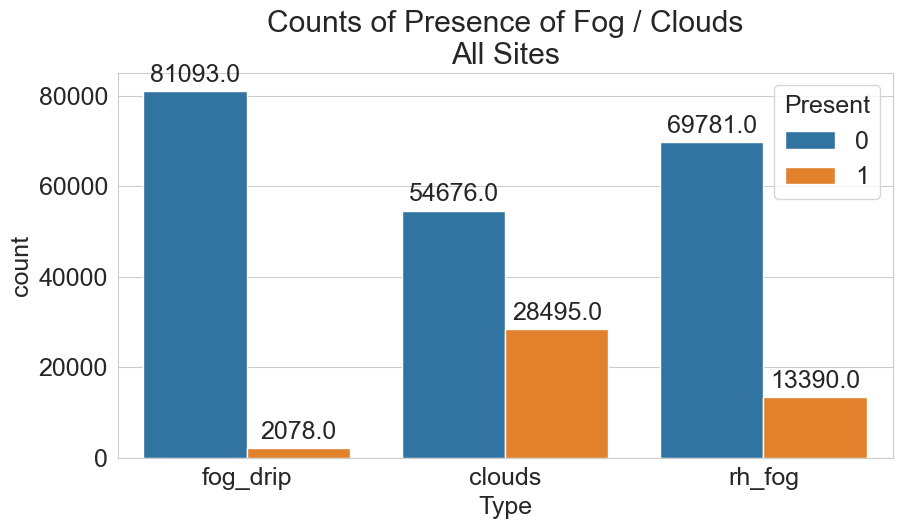

In [28]:
fog_drip_counts = join_df['fog-binary'].value_counts()
cld_bin_counts = join_df['cld-binary'].value_counts()
rh_fog_counts = join_df['rh-fog'].value_counts()

count_df = pd.DataFrame({'fog_drip' : fog_drip_counts,
                         'clouds' : cld_bin_counts,
                         'rh_fog' : rh_fog_counts})
count_df = count_df.reset_index().melt(id_vars='index', var_name='category', value_name='count')

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(count_df,
            x='category',
            y='count',
            hue='index',
            ax=ax)
ax.set(title='Counts of Presence of Fog / Clouds\nAll Sites',
       xlabel='Type')
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=3)
plt.legend(title='Present')
plt.show()

## RH Distributions

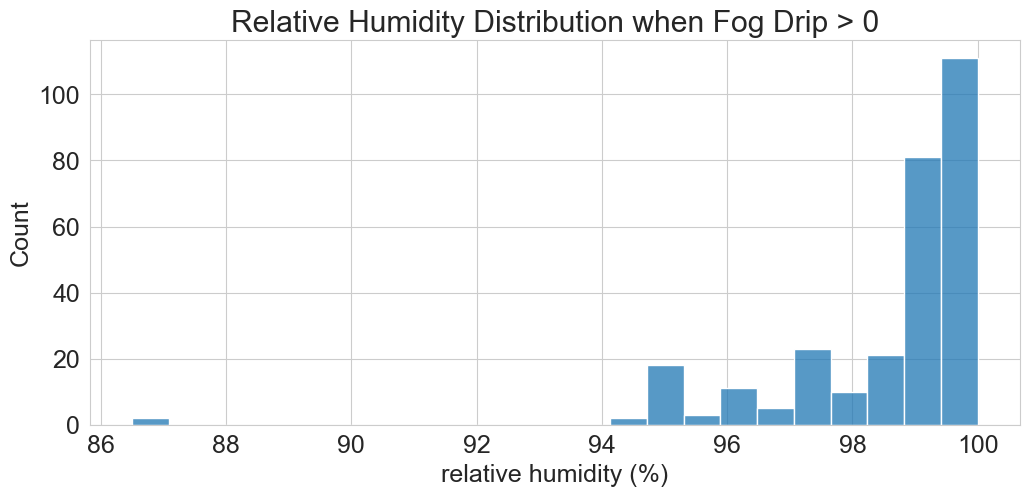

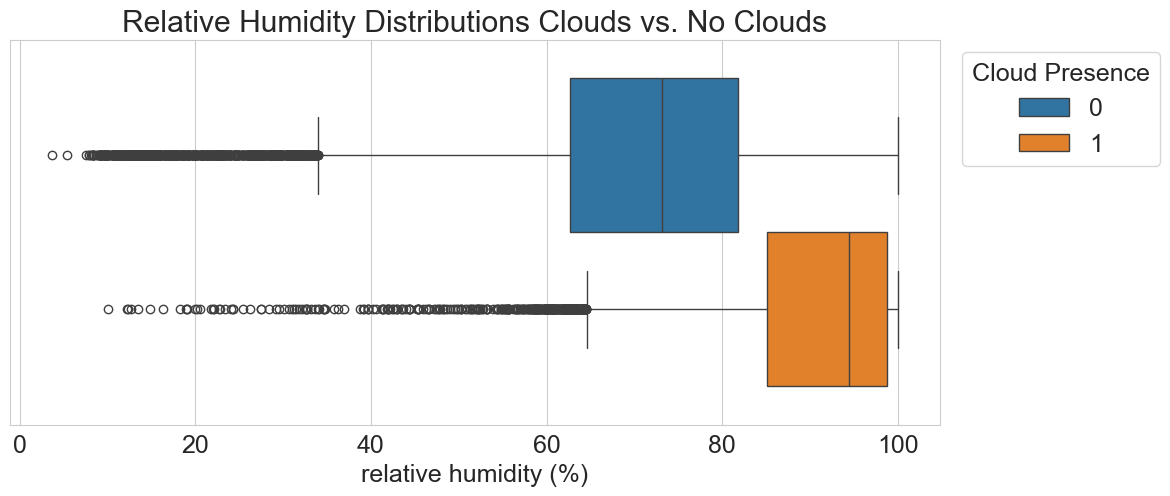

In [35]:
## What's the range of RH for fog drip? 
df_subset = df.loc[df['fog tips'] > 1]
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=df_subset,
            x='relative humidity (%)',
            ax=ax)
#ax.set_xbound(95, 100)
ax.set(title='Relative Humidity Distribution when Fog Drip > 0')
plt.show()

# Stratify distributions by CLC presence
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=df,
            x='relative humidity (%)',
            hue='cld-binary')
ax.set(title='Relative Humidity Distributions Clouds vs. No Clouds')
plt.legend(title='Cloud Presence', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

## Histograms

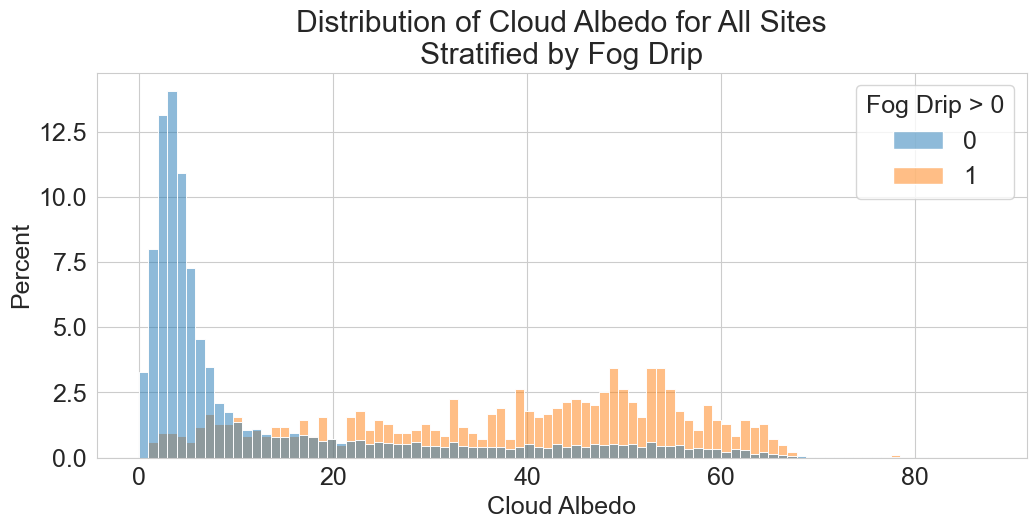

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=df,
             x='cldalb',
             stat='percent',
             hue='fog-binary',
             common_norm=False)
ax.set(title='Distribution of Cloud Albedo for All Sites\nStratified by Fog Drip',
       xlabel='Cloud Albedo')
ax.get_legend().set_title('Fog Drip > 0')
plt.show()

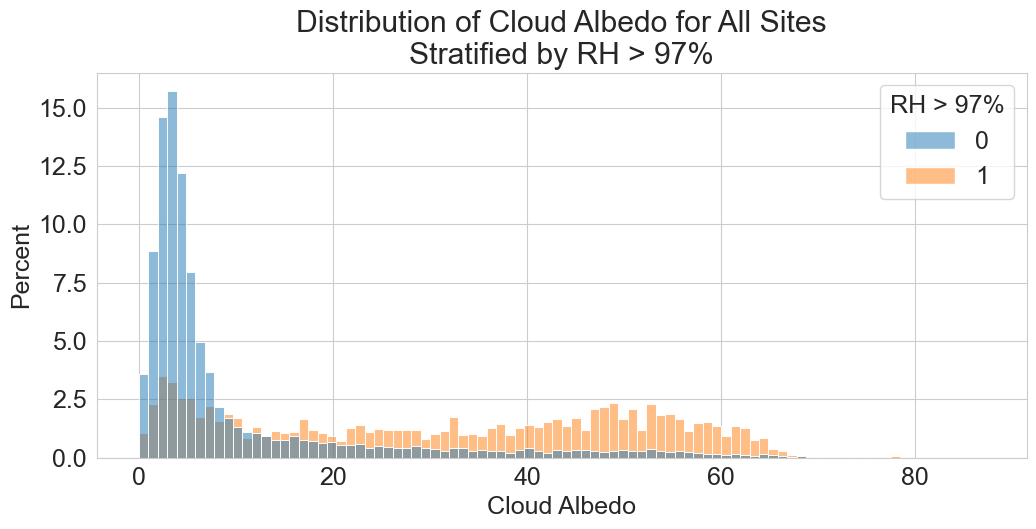

In [43]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=df,
             x='cldalb',
             stat='percent',
             hue='rh-fog',
             common_norm=False)
ax.set(title='Distribution of Cloud Albedo for All Sites\nStratified by RH > 97%',
       xlabel='Cloud Albedo')
ax.get_legend().set_title('RH > 97%')
plt.show()

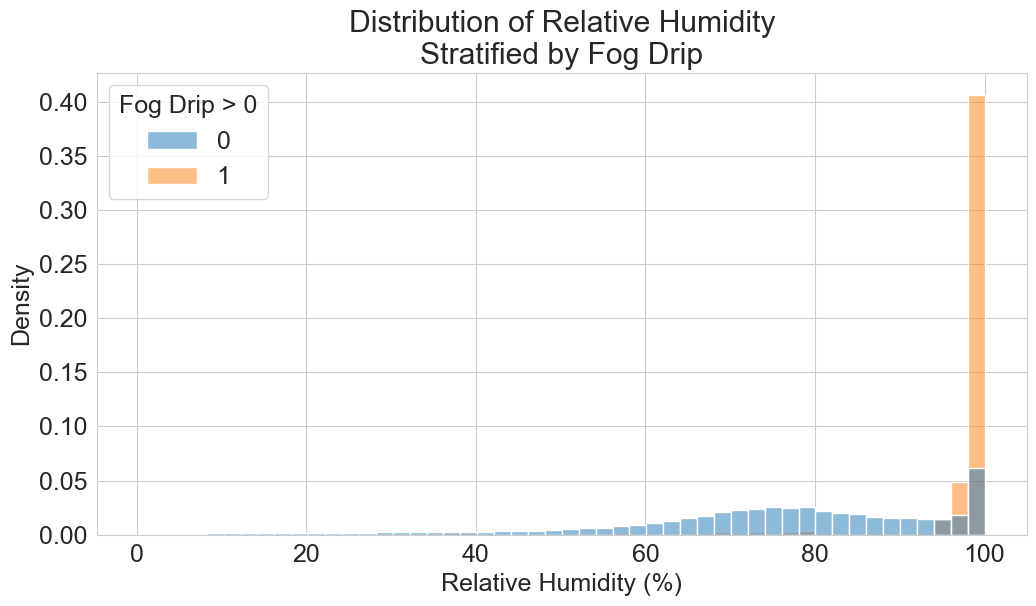

In [ ]:
# Histogram of cldalb values
fig, ax = plt.subplots(figsize=(12, 6))
xticks = np.arange(0, 100, 10)

bins=50
sns.histplot(data=join_df,
             x='relative humidity (%)',
             hue='fog-binary',
             stat='density',
             common_norm=False,
             bins=bins)
ax.set(title=f'Distribution of Relative Humidity\nStratified by Fog Drip',
       xlabel='Relative Humidity (%)')
ax.get_legend().set_title('Fog Drip > 0')
plt.show()


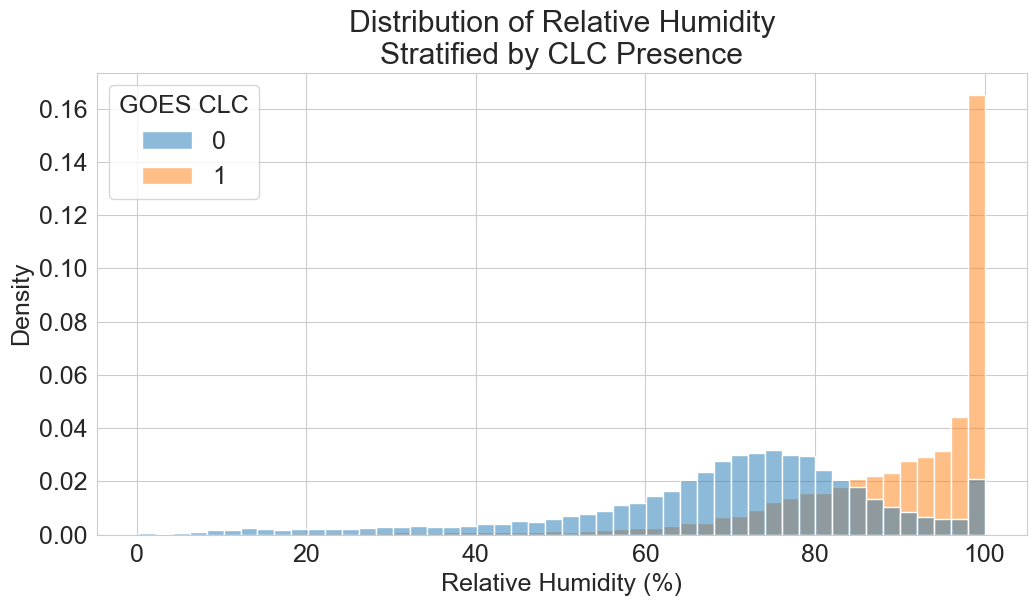

In [49]:
# Histogram of cldalb values
fig, ax = plt.subplots(figsize=(12, 6))
xticks = np.arange(0, 100, 10)

bins=50
sns.histplot(data=join_df,
             x='relative humidity (%)',
             hue='cld-binary',
             stat='density',
             common_norm=False,
             bins=bins)
ax.set(title=f'Distribution of Relative Humidity\nStratified by CLC Presence',
       xlabel='Relative Humidity (%)')
ax.get_legend().set_title('GOES CLC')

plt.show()


## Correlation Matrix

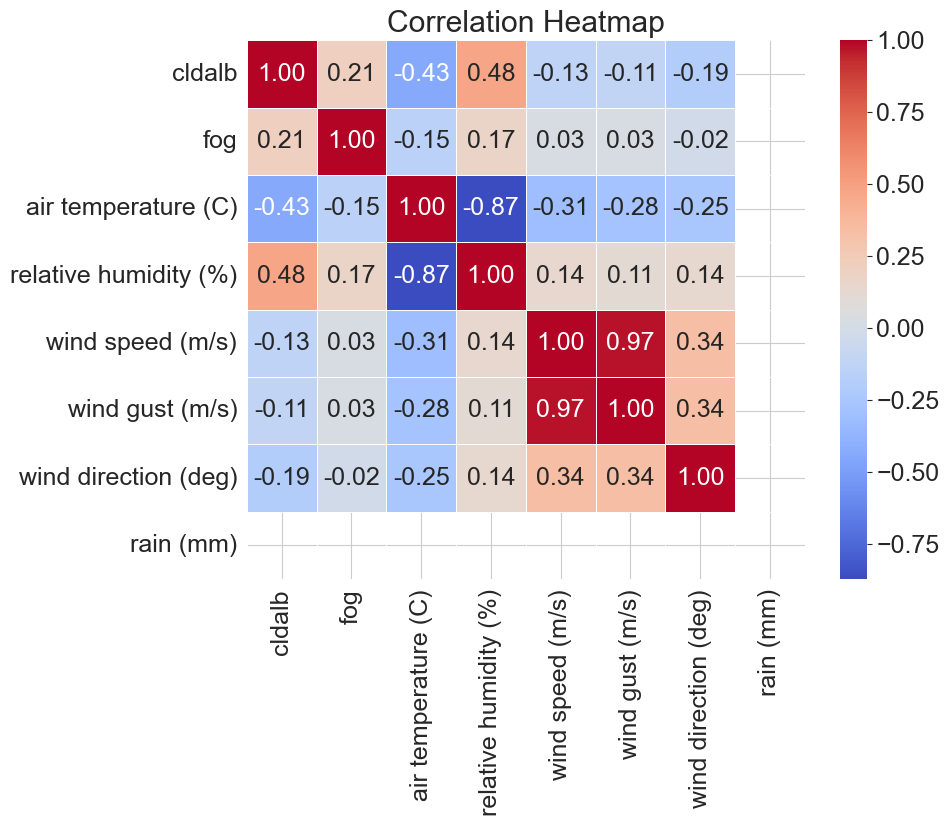

In [31]:
# Calculate the correlation matrix
corr_matrix = df[['cldalb', 'fog', 'air temperature (C)', 'relative humidity (%)',
       'wind speed (m/s)', 'wind gust (m/s)', 'wind direction (deg)',
       'rain (mm)']].corr()

# Create the heatmap
plt.figure(figsize=(9, 7))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Heatmaps: Fog / CLC Agreeance

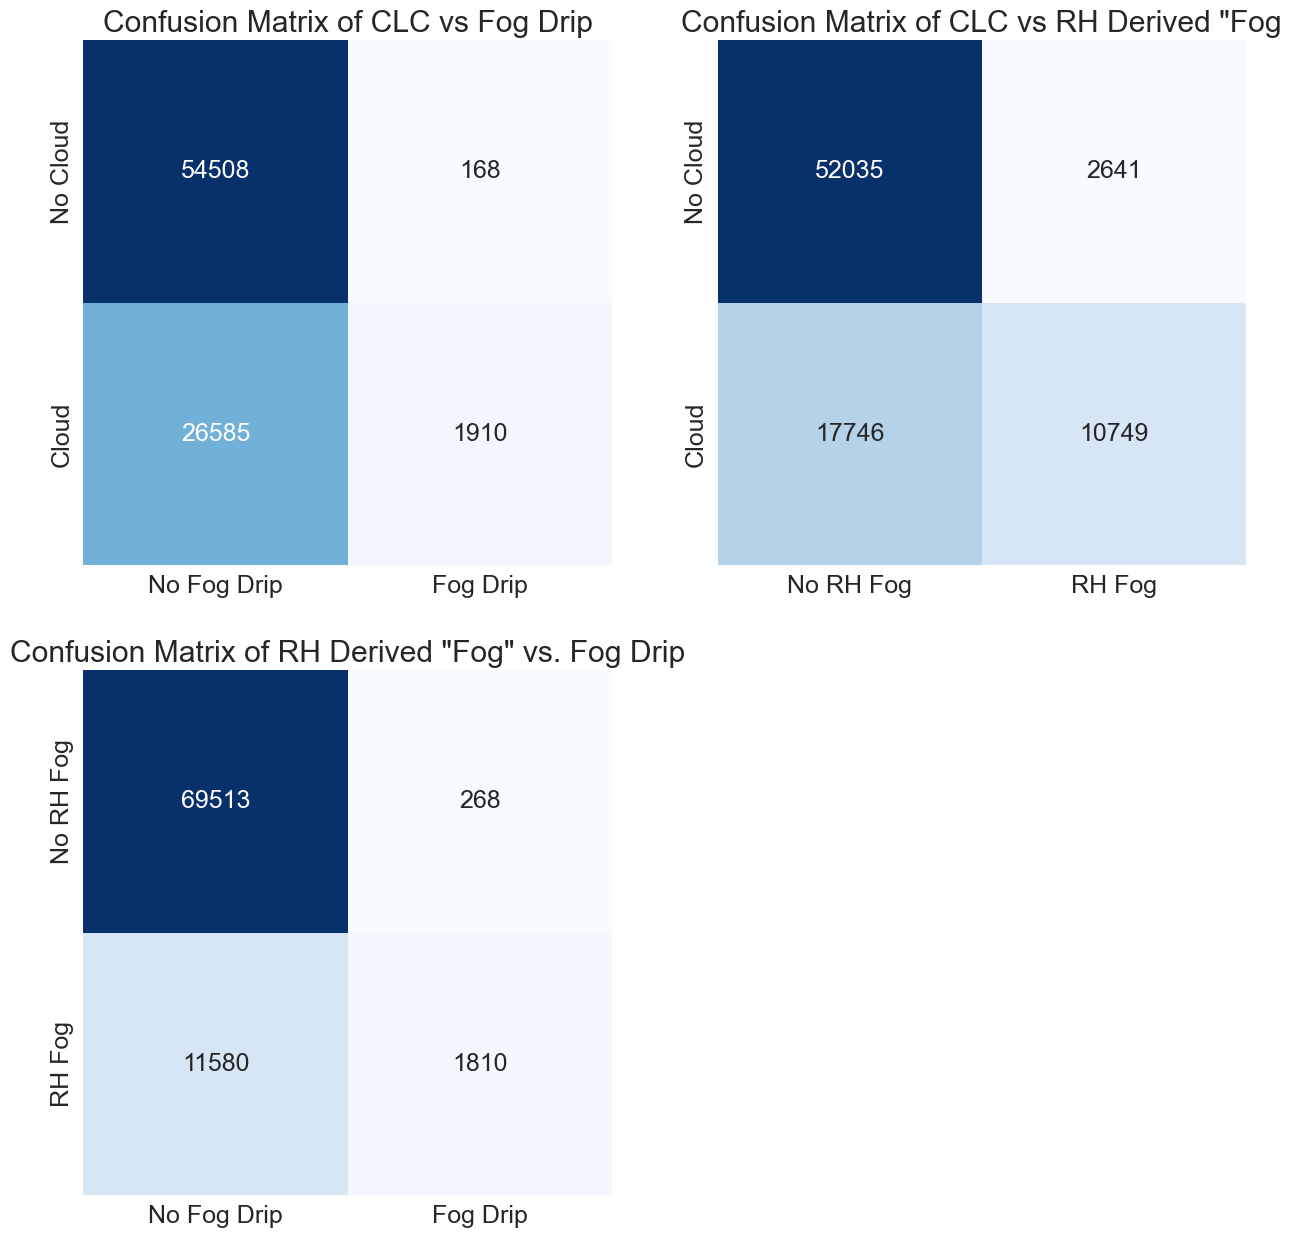

In [40]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
cm = confusion_matrix(join_df['cld-binary'], join_df['fog-binary'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fog Drip', 'Fog Drip'], yticklabels=['No Cloud', 'Cloud'], ax=ax[0,0],)
ax[0,0].set(title='Confusion Matrix of CLC vs Fog Drip')

cm = confusion_matrix(join_df['cld-binary'], join_df['rh-fog'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No RH Fog', 'RH Fog'], yticklabels=['No Cloud', 'Cloud'], ax=ax[0,1])
ax[0,1].set(title='Confusion Matrix of CLC vs RH Derived "Fog')

cm = confusion_matrix(join_df['rh-fog'], join_df['fog-binary'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fog Drip', 'Fog Drip'], yticklabels=['No RH Fog', 'RH Fog'], ax=ax[1,0])
ax[1, 0].set(title='Confusion Matrix of RH Derived "Fog" vs. Fog Drip')

ax[1,1].set_axis_off()


# Show the plot
plt.show()